Refine the tasks obtained using literature mining with GPT-4

In [21]:
import json
import fasttext
import os
from ontology_learner.json_utils import parse_jsonl_file
from pathlib import Path
import contextlib
import io
import re
import nltk
from nltk.corpus import stopwords
import umap
import numpy as np

nltk.download('stopwords')
english_stopwords = set(stopwords.words('english'))


datadir = Path('/Users/poldrack/Dropbox/data/ontology-learner/data')



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/poldrack/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def parse_jsonl_task_line(line):
    """Parses a single line of JSONL into a dictionary."""
    json_data = json.loads(line.strip())

    content = json_data['response']['body']['choices'][0]['message']['content']
    # clean up content
    content = content.replace("```json", "").replace("```", "")
    content_dict = json.loads(content)
    assert content_dict['type'] != 'other', f"type is other for {json_data['custom_id']}"
    content_dict['type'] = content_dict['type'].replace('task-', '')
    content_dict['type'] = content_dict['type'].replace('_', ' ')
    content_dict['description'] = ''.join(content_dict['description'])
    content_dict['model'] = json_data['response']['body']['model']
    content_dict['custom_id'] = json_data['custom_id'].replace('task-','').replace('/','_')
    content_dict['system_fingerprint'] = json_data['response']['body']['system_fingerprint']
    return content_dict



In [4]:
task_jsonl = list((datadir / 'task_results').glob('batch*.jsonl'))[0]

# context manager to suppress print statements
with contextlib.redirect_stdout(io.StringIO()) as f:
    tasks = list(parse_jsonl_file(task_jsonl, parse_jsonl_task_line))
print(f'Loaded {len(tasks)} tasks from {task_jsonl}')

# %%


Loaded 7495 tasks from /Users/poldrack/Dropbox/data/ontology-learner/data/task_results/batch_673a22e948a48190ad4e60083569448e.jsonl


In [5]:
# seriallize each task structure to a string
# after removing the following keys from the dictionary: 'type', 'system_fingerprint', 'model'
task_strings = {}
english_stopwords.update(['description', 'references',
                     'conditions', 'disorders', 'custom_id'])
for t in tasks:
    t_dict = t.copy()
    for k in ['type', 'system_fingerprint', 'model']:
        t_dict.pop(k)
    dictstr = json.dumps(t_dict)
    # remove punctuation
    dictstr = re.sub(r'[^\w\s]', '', dictstr)
    dictstr = dictstr.lower().replace('_', ' ')
    # remove one letter words
    dictstr = re.sub(r'\b\w\b', '', dictstr)
    # remove <> tags
    dictstr = re.sub(r'<[^>]*>', '', dictstr)
    # remove stopwords
    dictstr = ' '.join([word for word in dictstr.split() if word not in english_stopwords])
    task_strings[t['custom_id']] = dictstr

# %%

task_string_file = datadir / 'task_results' / 'task_strings.txt'
with open(task_string_file, 'w') as f:
    for s in task_strings.values():
        f.write(s + '\n')

# %%

Learn embedding using fasttext

In [6]:
model = fasttext.train_unsupervised(task_string_file.as_posix())

Read 0M words
Number of words:  10603
Number of labels: 0
Progress: 100.0% words/sec/thread:  130804 lr:  0.000000 avg.loss:  1.898325 ETA:   0h 0m 0s


In [7]:
embeddings = {}
for k, v in task_strings.items():
    embeddings[k] = model.get_word_vector(v)

# %%


Cluster tasks to find similar ones

In [12]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=None, distance_threshold=1.0)
cluster.fit(list(embeddings.values()))
cluster.labels_
# %%

array([188, 270, 353, ..., 334, 150,  77])

In [28]:
# create a dictionary mapping each cluster to a list of task ids
cluster_dict = {}
cluster_embeddings = {}
task_keys = list(embeddings.keys())

for i, l in enumerate(cluster.labels_):
    if l not in cluster_dict:
        cluster_dict[l] = []
    cluster_dict[l].append(task_keys[i])
    # append the embedding to the cluster embedding
    if l not in cluster_embeddings:
        cluster_embeddings[l] = []
    cluster_embeddings[l].append(embeddings[task_keys[i]])
# %%

In [30]:
# %%

(19, 100)

In [31]:
# for each clsuter, find outliers
for k, v in cluster_dict.items():
    emb = np.array(cluster_embeddings[k])
    
# %%

In [48]:
nof

array([-1.1045711, -0.9526644, -0.9526644], dtype=float32)

In [49]:
from sklearn.neighbors import LocalOutlierFactor
import warnings

lof = LocalOutlierFactor(n_neighbors=4, contamination=0.1)

nof_thresh = -1.1

for cluster_num in cluster_dict.keys():
    # suppress warning
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        outliers = lof.fit_predict(cluster_embeddings[cluster_num])
        nof = lof.negative_outlier_factor_

    # print outliers
    print(f'Cluster {cluster_num}')
    # print inliers
    for i, o in enumerate(outliers):
        if nof_thresh >= nof[i]:
            print(f'Inlier {i}: {cluster_dict[cluster_num][i]}')

    for i, o in enumerate(outliers):
        if nof_thresh < nof[i]:
            print(f'Outlier {i}: {cluster_dict[cluster_num][i]}')


    print()
# %%
# %%

Cluster 188
Inlier 2: spatial_generalization_task
Inlier 7: treasure_hunt_task
Inlier 9: sketch_map_task
Inlier 10: episodic_memory_task_involving_navigation_in_a_virtual_environment
Inlier 11: cognitive_map_recall_test
Inlier 13: virtual_reality_navigational_test
Inlier 14: maze_exploration
Inlier 17: sea_hero_quest_(shq)
Inlier 19: sea_hero_quest
Inlier 24: non-social_navigation_task
Inlier 28: maze_experiment
Inlier 33: spatial_learning_tasks
Outlier 0: modified_navigation_task
Outlier 1: virtual_reality_spatial_memory_task
Outlier 3: virtual_morris_water_navigation_(vmwn)
Outlier 4: virtual_navigation_task
Outlier 5: virtual_hebb-williams_maze
Outlier 6: cued_navigation_task
Outlier 8: virtual_navigation
Outlier 12: virtual_reality_maze_task
Outlier 15: spatial_navigation_performance
Outlier 16: spatial_navigation_task
Outlier 18: virtual_morris_water_maze
Outlier 20: navigation_task
Outlier 21: maze_tasks
Outlier 22: local_navigation_task
Outlier 23: navigation_pattern_task
Outlie

In [8]:
# reduce dimensionality using UMAP
reducer = umap.UMAP()
embeddings_2d = reducer.fit_transform(list(embeddings.values()))

# %%


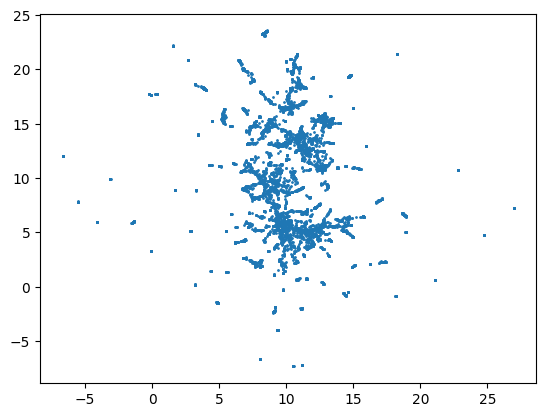

In [10]:
# plot using matplotlib
import matplotlib.pyplot as plt
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=1)
plt.show()

# %%


In [34]:
cluster_dict

{188: ['modified_navigation_task',
  'virtual_reality_spatial_memory_task',
  'spatial_generalization_task',
  'virtual_morris_water_navigation_(vmwn)',
  'virtual_navigation_task',
  'virtual_hebb-williams_maze',
  'cued_navigation_task',
  'treasure_hunt_task',
  'virtual_navigation',
  'sketch_map_task',
  'episodic_memory_task_involving_navigation_in_a_virtual_environment',
  'cognitive_map_recall_test',
  'virtual_reality_maze_task',
  'virtual_reality_navigational_test',
  'maze_exploration',
  'spatial_navigation_performance',
  'spatial_navigation_task',
  'sea_hero_quest_(shq)',
  'virtual_morris_water_maze',
  'sea_hero_quest',
  'navigation_task',
  'maze_tasks',
  'local_navigation_task',
  'navigation_pattern_task',
  'non-social_navigation_task',
  'vr_navigation_task',
  'spatial_learning_task',
  'maze_task',
  'maze_experiment',
  'navigation_tasks',
  'maze-based_tasks',
  'spatial_memory_tests',
  'virtual_spatial_navigation_task',
  'spatial_learning_tasks',
  'beha